# Multitask model training and analysis

In [ ]:
import os
import numpy as np
import pandas as pd
from math import ceil
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    mean_squared_error,
)
import torch
from torch.nn import CrossEntropyLoss
import sys
sys.path.append("../../../..")
from zeobind.src.utils.utils import setup_mpl, format_axs, get_color_values
setup_mpl()
colors = get_color_values(20, c='viridis_r')
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data_dir = "../../../data" 

In [4]:
pair_cols = ['SMILES', 'Zeolite']

# Analyze predictions

In [ ]:
# Load predictions

model_dir = f"{data_dir}/runs/mlp/multitask/1/multitask_0_b1.0_e1.0_l1.0_l20.1"
files = os.listdir(model_dir)
print("Prediction files:", [f for f in files if '.csv' in f])

preds = dict(train=None, val=None, test=None)
for k in preds.keys():
    preds[k] = pd.read_csv(f"{model_dir}/{k}_preds_unscaled.csv")
    preds[k].set_index(pair_cols, inplace=True)
    preds[k]['binding'] = preds[k][['nb', 'b']].values.argmax(axis=1)
    preds[k]['BE pred'] = preds[k]['binding'] * preds[k]['Binding (SiO2) pred']

Prediction files: ['test_preds_unscaled.csv', 'train_preds.csv', 'test_preds.csv', 'train_preds_unscaled.csv', 'val_preds.csv', 'val_preds_unscaled.csv']


In [6]:
# binary (b) task performance 
for k, v in preds.items():
    x = v['binding']
    y = v["('b',)"]
    print("\n", k)
    print("Confusion matrix:")
    print(confusion_matrix(x, y))
    f1 = f1_score(x, y)
    print("F1 score:", f1)


 train
Confusion matrix:
[[192684   5272]
 [ 10253 279123]]
F1 score: 0.9729421668226523

 val
Confusion matrix:
[[28546   738]
 [ 1394 34869]]
F1 score: 0.9703353276749686

 test
Confusion matrix:
[[26540   879]
 [ 1253 32712]]
F1 score: 0.9684409970987032


In [7]:
# energy (E) task performance 
for k, v in preds.items():
    x = v['Binding (SiO2) pred']
    y = v["('Binding (SiO2)',)"]

    # rmse 
    rmse = np.sqrt(mean_squared_error(y, x))
    print(f"{k} RMSE: {rmse:.3f} kJ/ mol Si")

train RMSE: 1.143 kJ/ mol Si
val RMSE: 1.011 kJ/ mol Si
test RMSE: 1.120 kJ/ mol Si


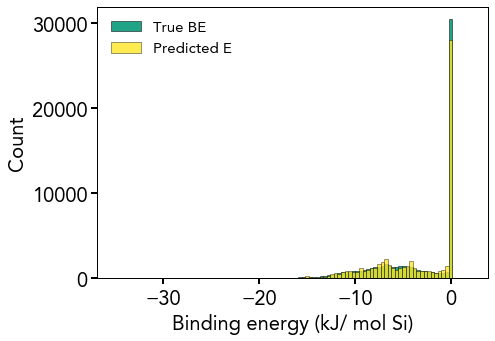

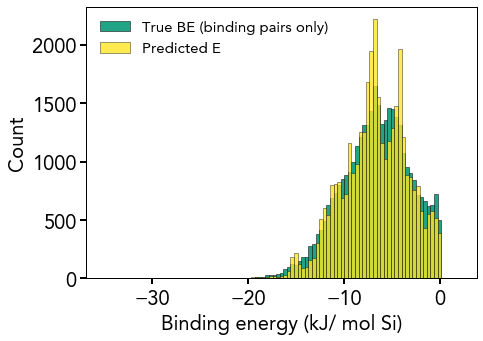

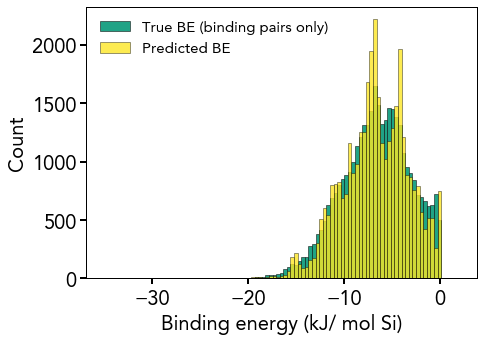

In [18]:
# all E predictions
bins = np.linspace(-35, 2, 100)
hist_kwargs = dict(bins=bins, linewidth=0.5, edgecolor='k')
v = preds['val']

fig, axs = plt.subplots(figsize=(7, 5))
axs.hist(v["('Binding (SiO2)',)"], alpha=1.0, label='True BE', color=colors[8], **hist_kwargs)
axs.hist(v['Binding (SiO2) pred'], alpha=0.8, label='Predicted E', color=colors[0], **hist_kwargs)
axs = format_axs(axs, 20, 20, 1, "Binding energy (kJ/ mol Si)", "Count", 20, 20)
axs.legend(frameon=False, fontsize=15);

# E predictions corresponding to ground truth binding pairs only
fig, axs = plt.subplots(figsize=(7, 5))
v = v[~v["('Binding (SiO2)',)"].between(-1e-7, 1e-7)]
axs.hist(v["('Binding (SiO2)',)"], alpha=1.0, label='True BE (binding pairs only)', color=colors[8], **hist_kwargs)
axs.hist(v['Binding (SiO2) pred'], alpha=0.8, label='Predicted E', color=colors[0], **hist_kwargs)
axs = format_axs(axs, 20, 20, 1, "Binding energy (kJ/ mol Si)", "Count", 20, 20)
axs.legend(frameon=False, fontsize=15);

# BE predictions corresponding to ground truth binding pairs only
fig, axs = plt.subplots(figsize=(7, 5))
v = preds['val']
v = v[~v["('Binding (SiO2)',)"].between(-1e-7, 1e-7)]
axs.hist(v["('Binding (SiO2)',)"], alpha=1.0, label='True BE (binding pairs only)', color=colors[8], **hist_kwargs)
axs.hist(v['BE pred'], alpha=0.8, label='Predicted BE', color=colors[0], **hist_kwargs)
axs = format_axs(axs, 20, 20, 1, "Binding energy (kJ/ mol Si)", "Count", 20, 20)
axs.legend(frameon=False, fontsize=15);

In [9]:
# binding energy (BE) task performance 
for k, v in preds.items():
    x = v['BE pred']
    y = v["('Binding (SiO2)',)"]

    # rmse 
    rmse = np.sqrt(mean_squared_error(y, x))
    print(f"{k} RMSE: {rmse:.3f} kJ/ mol Si")

train RMSE: 1.145 kJ/ mol Si
val RMSE: 1.013 kJ/ mol Si
test RMSE: 1.127 kJ/ mol Si


In [ ]:
# spearman and pearson coefficient per molecule 
spearmans = dict(train=None, val=None, test=None)
pearsons = dict(train=None, val=None, test=None)
print("Multitask MLP model:")
for k, v in preds.items():
    spearmans[k] = v.groupby(pair_cols[0]).apply(lambda x: spearmanr(x['BE pred'], x["('Binding (SiO2)',)"])[0])
    pearsons[k] = v.groupby(pair_cols[0]).apply(lambda x: pearsonr(x['BE pred'], x["('Binding (SiO2)',)"])[0])
    print(f"{k} Spearman average: {spearmans[k].mean():.3f}")
    print(f"{k} Pearson average: {pearsons[k].mean():.3f}")

Multitask MLP model:
train Spearman average: 0.963
train Pearson average: 0.963
val Spearman average: 0.968
val Pearson average: 0.970
test Spearman average: 0.959
test Pearson average: 0.957


In [ ]:
# Compare with single task MLP model
test_data_ranks_mlp = pd.read_csv(f"{data_dir}/publication/model_performance/test_data_ranks.csv", index_col=0)
print("Single task MLP models:")
print(test_data_ranks_mlp.mean())

Single task MLP models:
test_spearman    0.961147
test_pearson     0.960790
dtype: float64


In [12]:
# loading (l_uc) task performance 
criterion = CrossEntropyLoss()
for k, v in preds.items():
    x = v[[f'load_norm_{i} pred' for i in range(46)]]
    y = v[[f"('load_norm_{i}',)" for i in range(46)]]
    y = y.idxmax(axis=1).apply(lambda x: int(x.split('_')[-1].split("'")[0]))
    loss = criterion(torch.tensor(x.values), torch.tensor(y.values))
    print(f"{k} loading CELoss: {loss:.2f}")

train loading CELoss: 0.52
val loading CELoss: 0.46
test loading CELoss: 0.49


# Heldout set performance

In [ ]:
heldout_pred_file = f"{data_dir}/predictions/multitask/multitask/osda_priors_0_zeolite_priors_0_preds.csv"
heldout_preds = pd.read_csv(heldout_pred_file, index_col=0)
heldout_preds.set_index(pair_cols, inplace=True)
heldout_preds["BE pred"] = heldout_preds["b"] * heldout_preds["Binding (SiO2)"]

In [ ]:
heldout_truth = pd.read_csv(f"{data_dir}/datasets/heldout_hyp_mols/heldout_data.csv", index_col=0)
heldout_truth.set_index(pair_cols, inplace=True)
heldout_truth['charge'] = heldout_truth.index.get_level_values(pair_cols[0]).map(lambda x: x.count('+]') - x.count('[-'))
heldout_preds = heldout_preds.loc[heldout_truth.index]

Heldout RMSE for 1+ molecules: 1.304 kJ/ mol Si
Heldout RMSE for 2+ molecules: 2.060 kJ/ mol Si


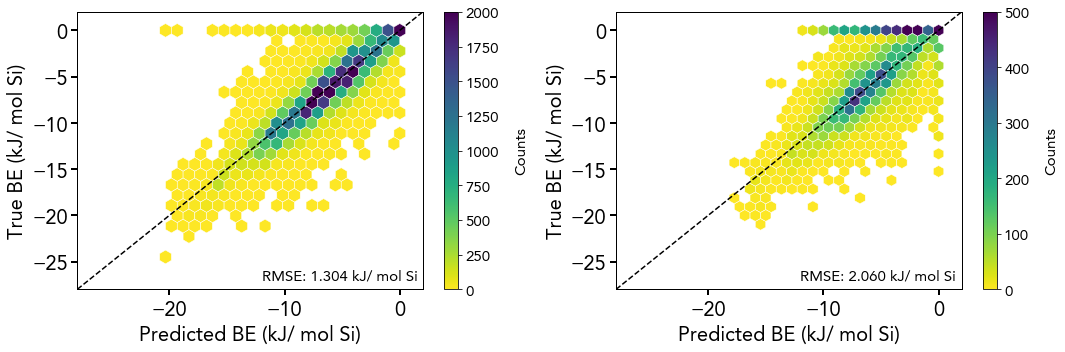

In [15]:
vmaxes = [2000, 500]
limits = dict(x=(-28, 2), y=(-28, 2))
gridsize = list([ceil((l[1] - l[0]) / 1.5) for l in limits.values()])
gridsize[1] = int(gridsize[0] / np.sqrt(3))
hexbin_kwargs = dict(mincnt=1, gridsize=gridsize, cmap='viridis_r', vmin=0, linewidths=0.5, edgecolors='w')

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for i, charge in enumerate([1, 2]):
    y = heldout_truth[heldout_truth['charge'] == charge]['Binding (SiO2)']
    x = heldout_preds.loc[y.index]["BE pred"]
    rmse = np.sqrt(mean_squared_error(y, x))
    print(f"Heldout RMSE for {charge}+ molecules: {rmse:.3f} kJ/ mol Si")

    # plot
    sc = axs[i].hexbin(x, y, vmax=vmaxes[i], label=f"{charge}+ hypothetical molecules", **hexbin_kwargs)
    axs[i] = format_axs(axs[i], 20, 20, 1, "Predicted BE (kJ/ mol Si)", "True BE (kJ/ mol Si)", 20, 20, limits=limits)
    cbar = plt.colorbar(sc, ax=axs[i])
    cbar.set_label('Counts', labelpad=15, fontsize=15)
    cbar.ax.tick_params(labelsize=15)
    # parity line 
    axs[i].plot(limits['x'], limits['y'], 'k--')
    # annotate 
    axs[i].text(-12, -27, f"RMSE: {rmse:.3f} kJ/ mol Si", fontsize=15)

fig.tight_layout()